In [1]:
import copy
import numpy as np
import matplotlib.pylab as pl
%matplotlib inline
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import my

In [2]:
N_TRAIN, N_TEST = 0, 0
train_data, train_labels, test_data, test_labels = my.unbalanced_cifar10(N_TRAIN, N_TEST, p=[])

train_data = th.from_numpy(train_data).float()
train_labels = th.from_numpy(train_labels).long()
test_data = th.from_numpy(test_data).float()
test_labels = th.from_numpy(test_labels).long()

cuda = True
if cuda:
    th.cuda.set_device(3)

BATCH_SIZE = 1024
train_loader = DataLoader(TensorDataset(train_data, train_labels), BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data, test_labels), BATCH_SIZE)

N_FEATURES = train_data.size()[1]
N_CLASSES = int(train_labels.max() - train_labels.min() + 1)

In [3]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 2, 1)
        self.conv2 = nn.Conv2d(16, 8, 3, 2, 1)
        self.linear = nn.Linear(8, n_classes)
    
    def forward(self, x):
        if x.dim() != 4:
            x = x.view(-1, 3, 32, 32)
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 8)
        x = self.linear(x.view(-1, 8))
        return x

In [4]:
%%capture
STD = 1e-0

th.random.manual_seed(1)
th.cuda.manual_seed_all(1)

# c = nn.Linear(N_FEATURES, N_CLASSES)
# c = my.MLP((N_FEATURES,) + (64,) * 3 + (N_CLASSES,), F.relu)
c = CNN(N_CLASSES)
c_bar = copy.deepcopy(c)
c.eval()
c_bar.eval()

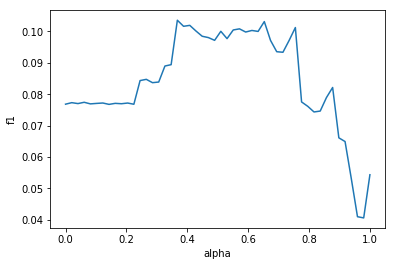

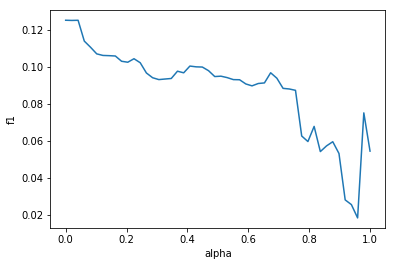

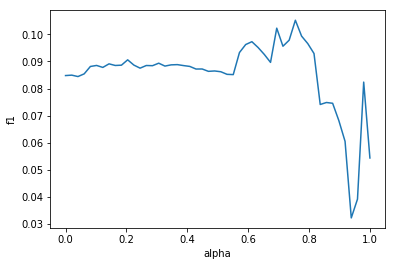

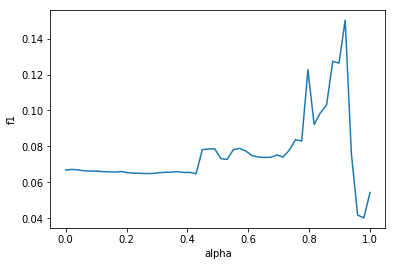

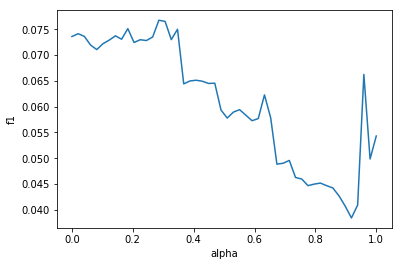

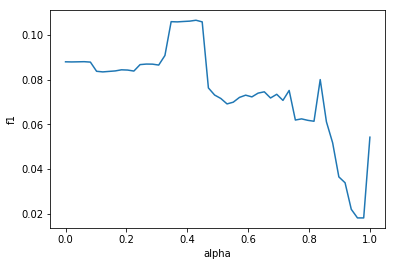

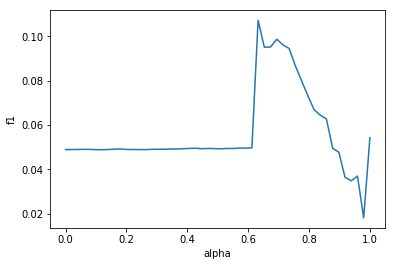

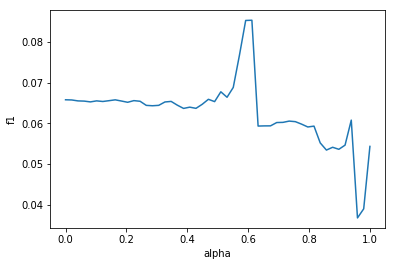

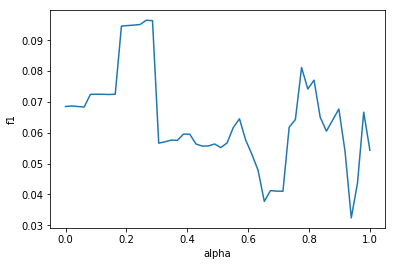

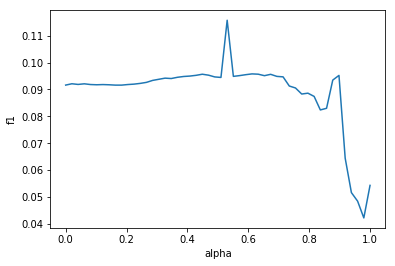

In [5]:
alpha = np.linspace(0, 1)
f1 = np.zeros(alpha.shape)
for i in range(10):
    c_prime = my.perturb(c, STD)
    c_prime.eval()
    for j, a in enumerate(alpha):
        c_params = c.parameters()
        c_prime_params = c_prime.parameters()
        c_bar_params = c_bar.parameters()
        for p, p_prime, p_bar in zip(c_params, c_prime_params, c_bar_params):
            p_bar.data = a * p.data + (1 - a) * p_prime.data
        f1[j] = my.global_stats(c_bar, train_loader, my.nd_curry(my.nd_f_beta, N_CLASSES))
    pl.figure()
    pl.plot(alpha, f1)
    pl.xlabel('alpha')
    pl.ylabel('f1')